# GPCP（月平均资料）

对 1979 年至 2023 年 月平均 GCPCP 降水数据进行了初步分析：
* 趋势
* 气候态年平均降水量
* 降水率的面积加权平均值
* 纬向平均降水量

**数据**

月平均 GPCP（全球降水气候学项目）数据融合了测量站、卫星和探空观测的降雨量，以估计 1979 年至今 2.5 度全球网格上的月降雨量。

更多信息可在 https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project 上找到。

# 数据读取

In [20]:
import numpy as np
import scipy.stats as stats
import datetime 
from netCDF4 import Dataset as netcdf # netcdf4-python module
from cartopy.mpl.ticker import  LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker
import xarray as xr
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.simplefilter('ignore')
path = r'I:/precip.mon.mean.nc'

# 读取数据
ds = xr.open_dataset(path).sel(time=slice('1979-01-01', '2023-12-01'))


lons   = ds ['lon'][:]
lats   = ds ['lat'][:]
time   = ds ['time'][:]
pr     = ds ['precip'][:]

ds


<xarray.Dataset> Size: 22MB
Dimensions:    (lat: 72, lon: 144, time: 540, nv: 2)
Coordinates:
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 9kB ...
    lat_bnds   (lat, nv) float32 576B ...
    lon_bnds   (lon, nv) float32 1kB ...
    precip     (time, lat, lon) float32 22MB ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2024/06 through latest.

In [21]:
time[0:5]

<xarray.DataArray 'time' (time: 5)> Size: 40B
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', '1979-04-01T00:00:00.000000000',
       '1979-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 40B 1979-01-01 1979-02-01 ... 1979-05-01
Attributes:
    long_name:      Time
    delta_t:        0000-01-00 00:00:00
    avg_period:     0000-01-00 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [65378. 81996.]

In [22]:
undef = -99999.0
pr.data[pr.data==undef] = np.nan

nt,nlat,nlon = pr.shape
ngrd = nlat*nlon
nt,nlat,nlon

(540, 72, 144)


## 计算趋势并分析
- 将降水数据 pr.data 重塑为 (nt, ngrd) 的形状，其中 nt 是时间步数，ngrd 是网格点数。order='F' 表示按列优先重塑
- 初始化两个空数组 pr_rate 和 pr_val，用于存储每个网格点的降水变化率和p值，并将它们的值设为 NaN
- 遍历每个网格点 i
- 提取该网格点的时间序列数据 y，并去除 NaN 值，得到 y0
- 创建一个与 y0 长度相同的线性空间 x
- 使用 stats.linregress 进行线性回归，计算斜率 slope、截距 intercept、相关系数 r_value、p值 p_value 和标准误差 std_err
- 将斜率乘以120（假设数据是月度数据，转换为每十年的变化率）并存储在 pr_rate 中
- 将p值存储在 pr_val 中


In [44]:
pr_grd  = pr.data.reshape((nt, ngrd), order='F') 
pr_rate = np.empty((ngrd,1))
pr_rate[:,:] = np.nan
pr_val = np.empty((ngrd,1))
pr_val[:,:] = np.nan

for i in range(ngrd): 
    print(i)
    y = pr_grd[:,i]  
    y0 = y[~np.isnan(y)]    
   
    x = np.linspace(1,len(y0), len(y0))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y0)
    pr_rate[i,0] = slope*120.0  
    pr_val[i,0]  = p_value 

pr_rate.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(10368, 1)

In [45]:

pr_rate = pr_rate.reshape((nlat,nlon), order='F')
pr_val  = pr_val.reshape((nlat,nlon), order='F')

pr_rate.shape

(72, 144)

## 可视化趋势

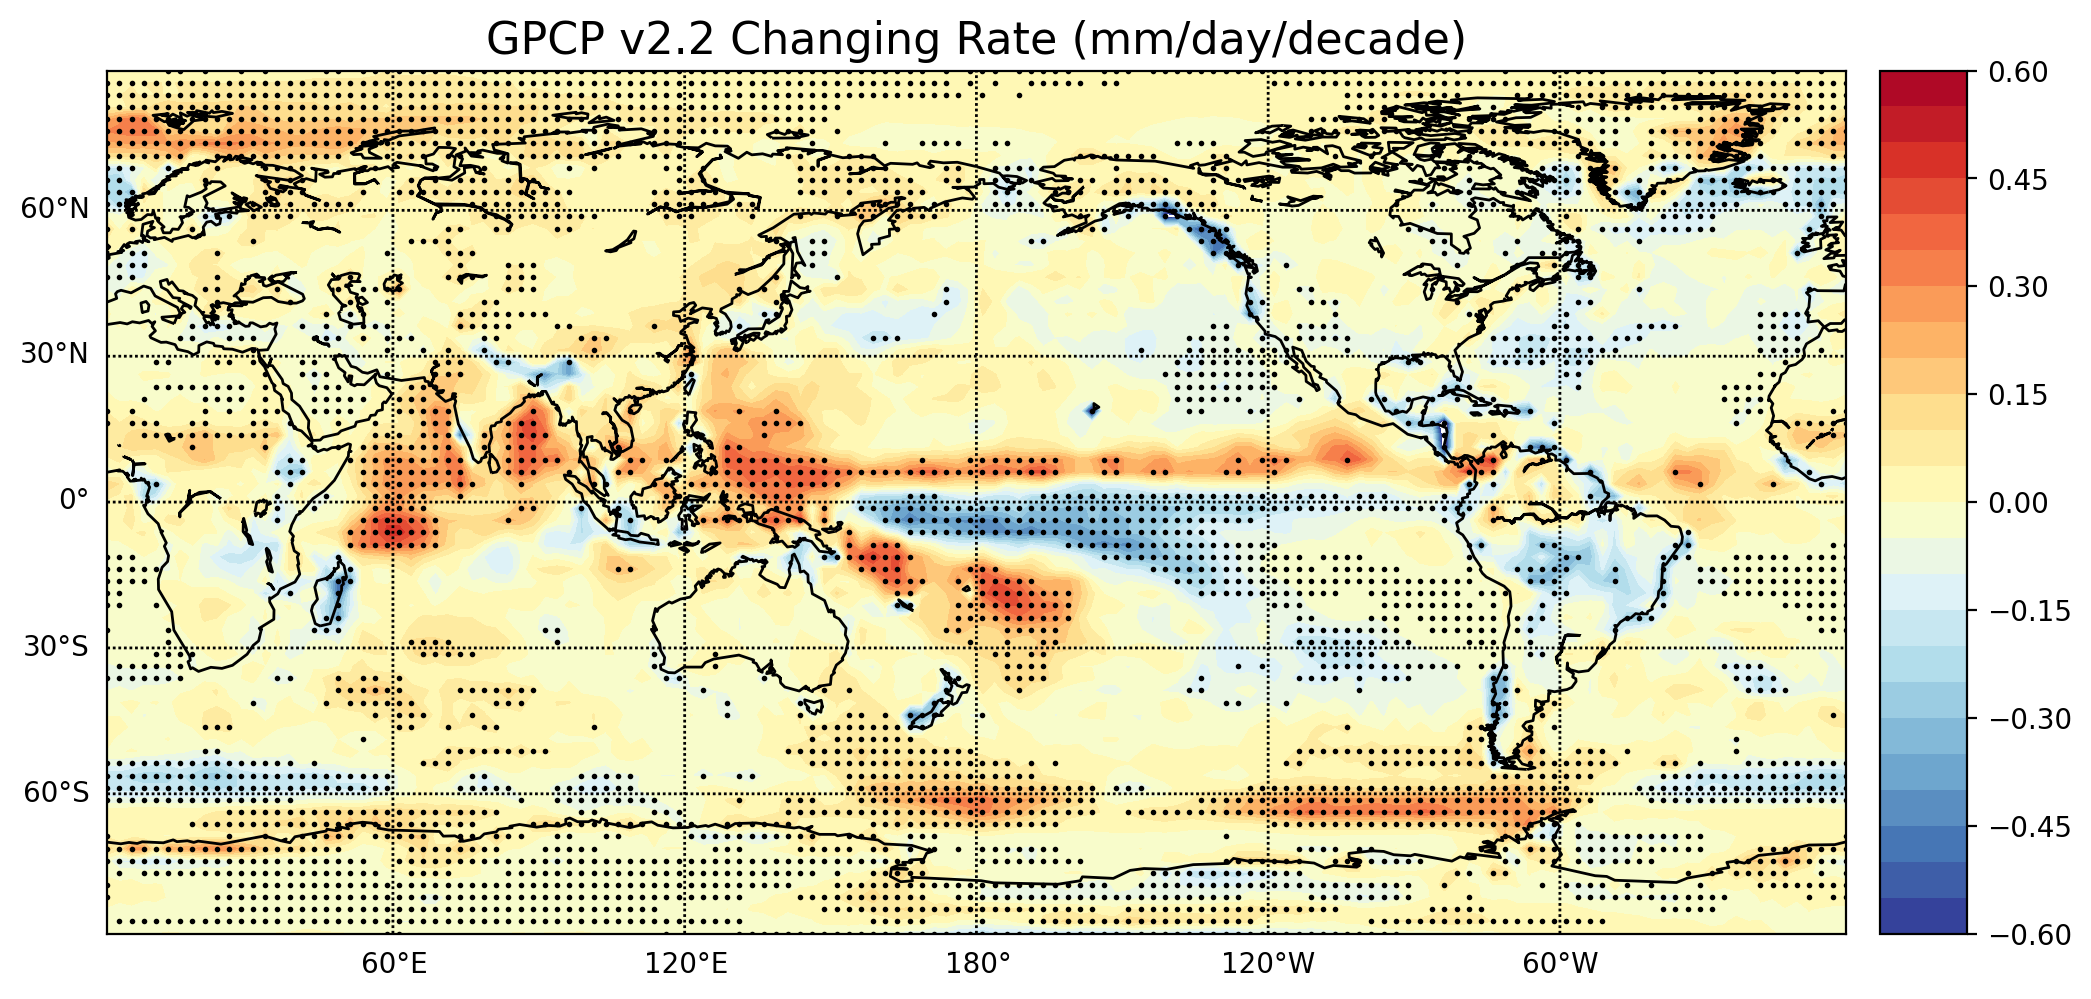

In [54]:
plt.figure(figsize=(12,6),dpi=200)
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-0.6, 0.6, 25)
cs = m.contourf(x, y, pr_rate.squeeze(), clevs, cmap='RdYlBu_r')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180.,181.,60.), labels=[0,0,0,1], fontsize=10)
cb = m.colorbar(cs)
plt.title('GPCP v2.2 Changing Rate (mm/day/decade)', fontsize=16)

sig_lats, sig_lons = np.where(pr_val < 0.05)
m.scatter(lons[sig_lons], lats[sig_lats], marker='o', color='k', s=1)

plt.show()

## 气候态年平均 

In [25]:
pr_ann_clm  = np.nanmean(pr, axis=0)

Text(0.5, 1.0, 'GPCP v2.2 Annual Mean (mm/day)')

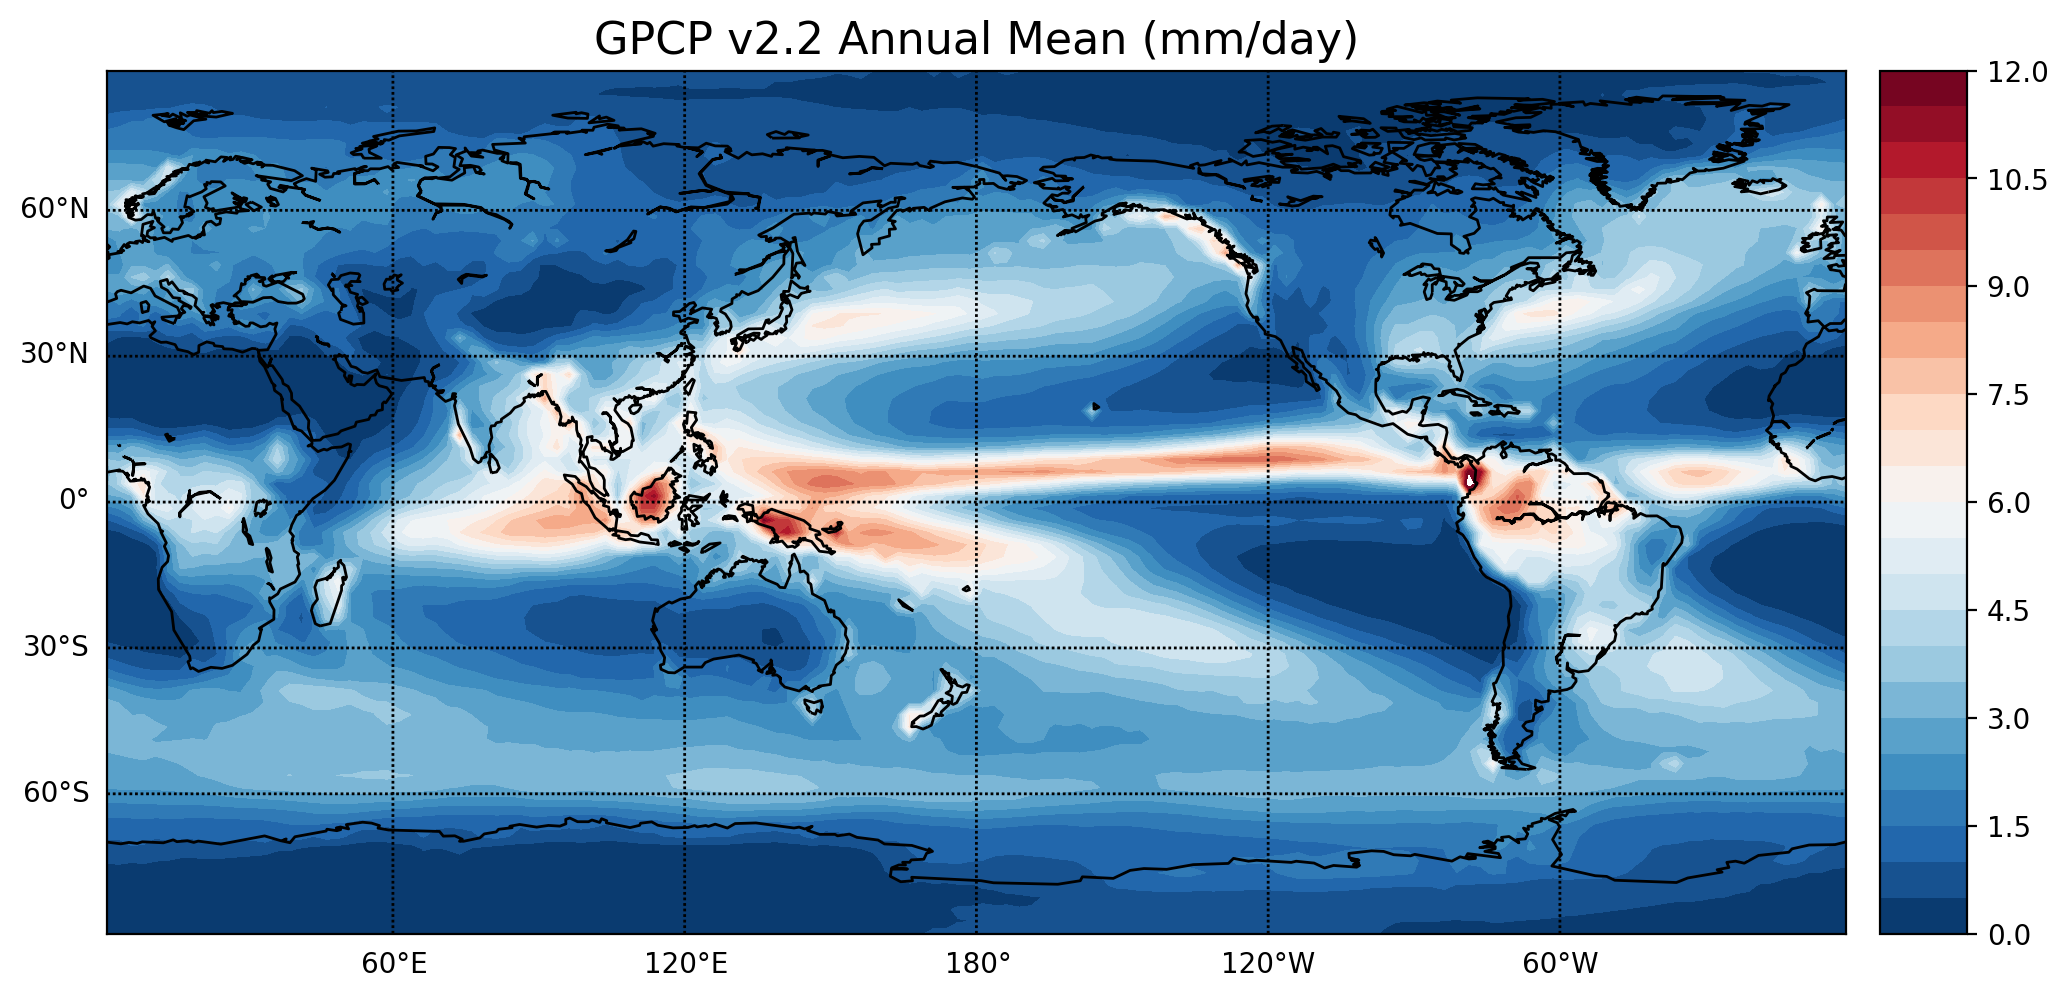

In [34]:
plt.figure(figsize=(12,6),dpi=200)
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(0.0, 12.0, 25)
cs = m.contourf(x, y, pr_ann_clm.squeeze(), clevs, cmap=plt.cm.RdBu_r)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,30.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180.,181.,60.), labels=[0,0,0,1], fontsize=10)
cb = m.colorbar(cs)
plt.title('GPCP v2.2 Annual Mean (mm/day)', fontsize=16)

## 区域加权平均 

In [27]:
lonx, latx = np.meshgrid(lons, lats)
weights = np.cos(latx * np.pi / 180.)

pr_glb_avg = np.zeros(nt)

for it in np.arange(nt):
    pone = pr[it,:, :]
    pone = np.ma.masked_array(pone, mask=np.isnan(pone))
    pr_glb_avg[it] = np.average(pone, weights=weights) 
    
glb_avg = np.mean(pr_glb_avg)
print(glb_avg)

2.6877014447141576


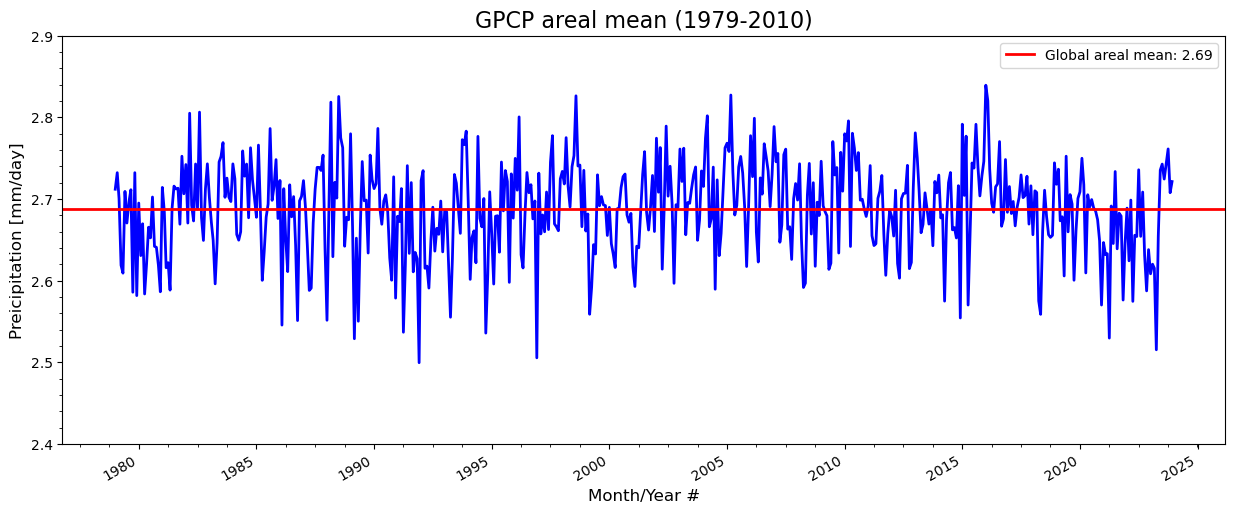

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

ax.plot(time, pr_glb_avg, color='b', linewidth=2)

ax.axhline(glb_avg, linewidth=2, color='r', label="Global areal mean: " + str(np.round(glb_avg*100)/100))
ax.legend()
ax.set_title('GPCP areal mean (1979-2010)', fontsize=16)
ax.set_xlabel('Month/Year #', fontsize=12)
ax.set_ylabel('Preicipitation [mm/day]', fontsize=12)
ax.set_ylim(2.4, 2.9)
ax.minorticks_on()
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y')

## 计算纬向平均

In [30]:
pr_ann_clm   = np.nanmean(pr, axis=0)
pr_ann_zonal = np.nanmean(pr_ann_clm, axis=1)

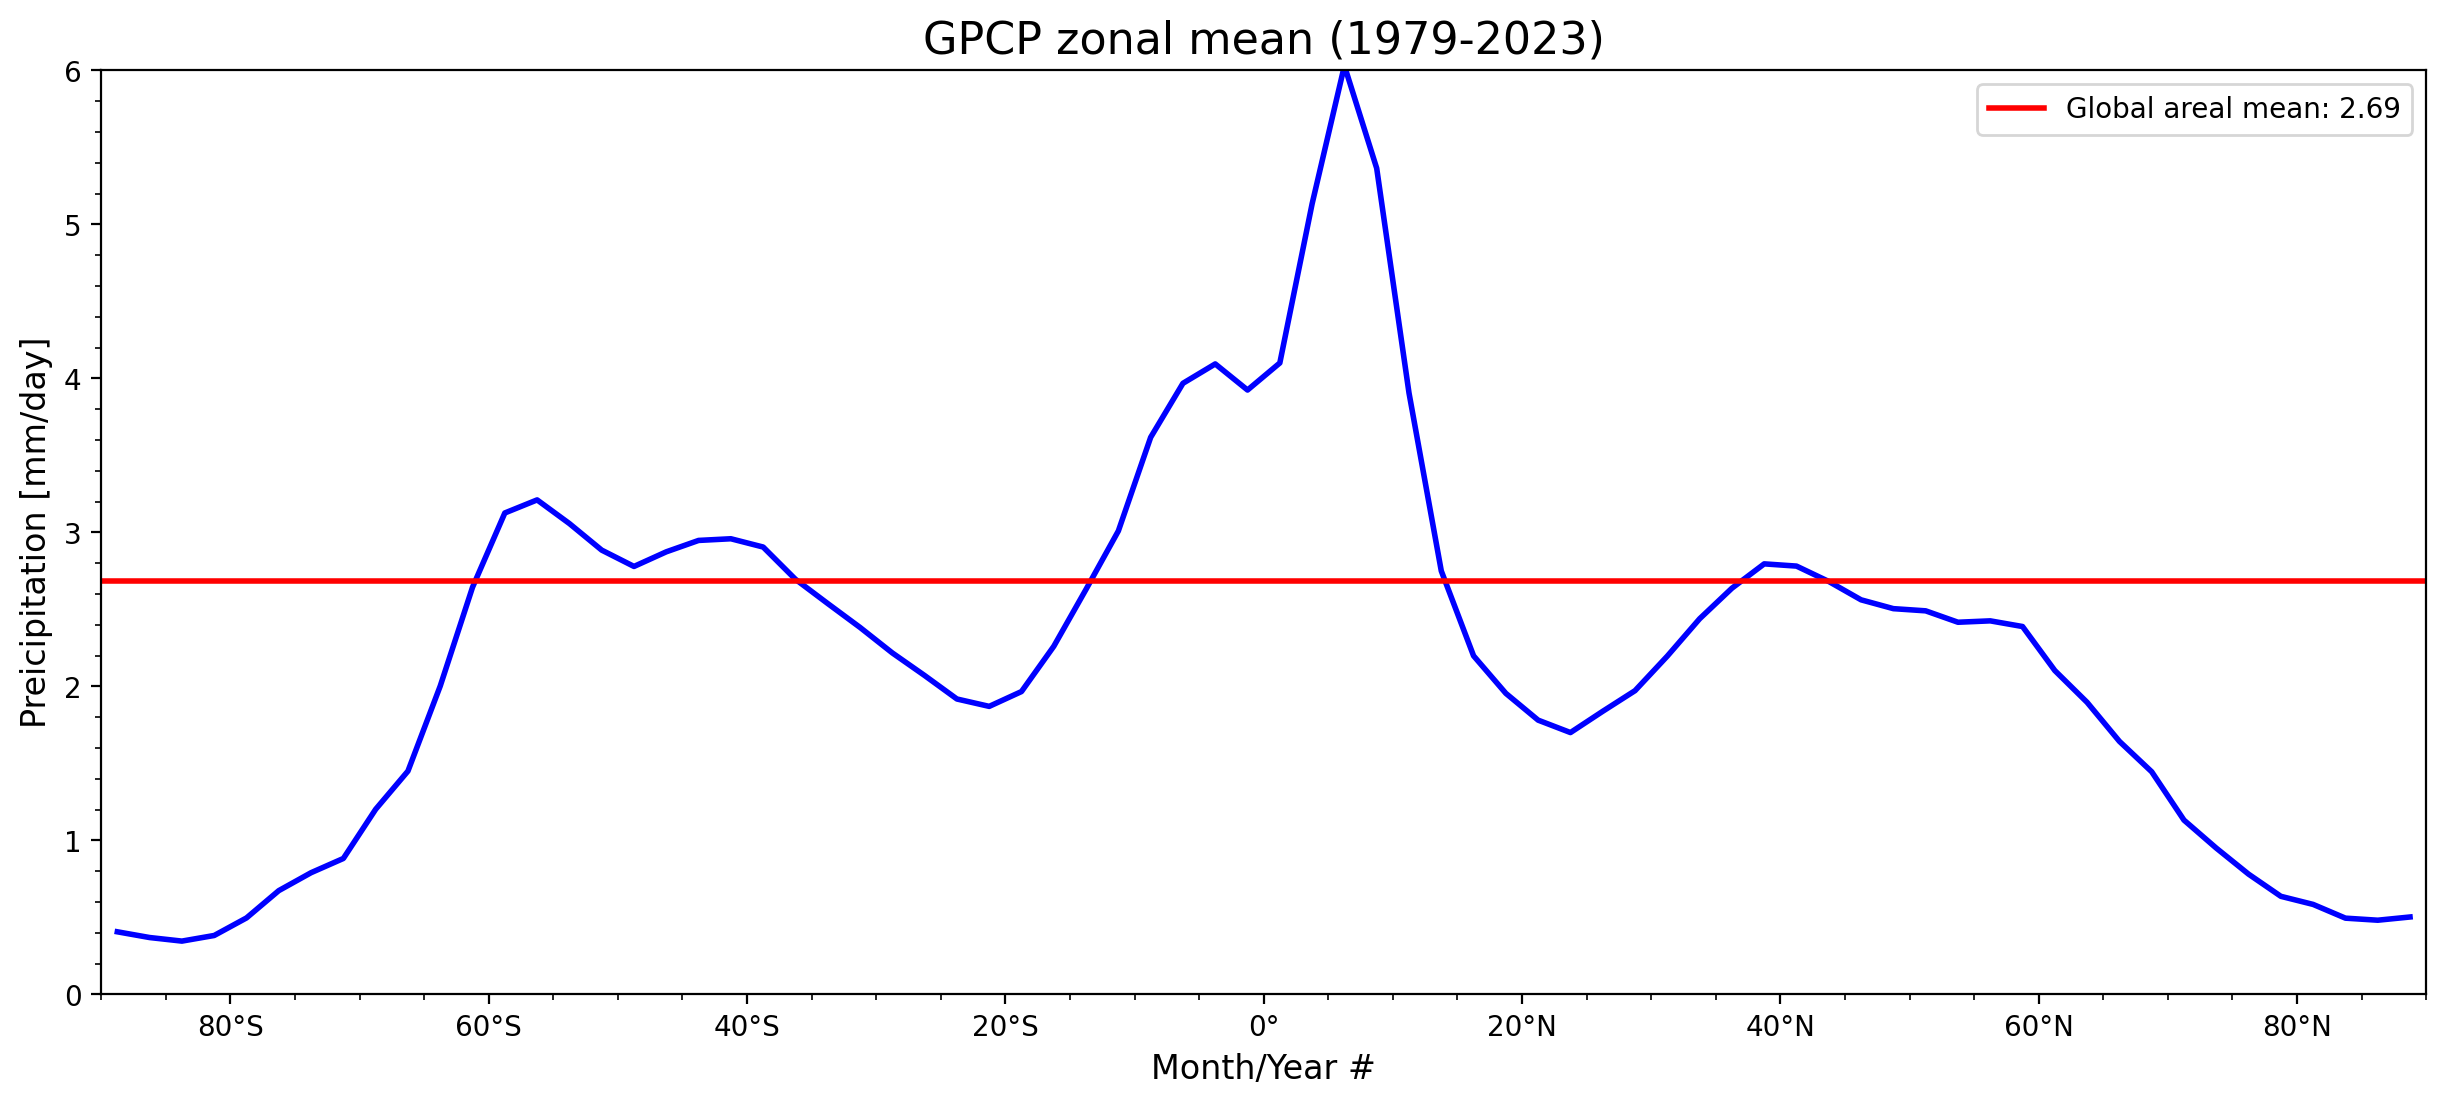

In [32]:

fig, ax = plt.subplots(1, 1, figsize=(15,6),dpi=200)

ax.plot(lats, pr_ann_zonal, color='b', linewidth=2)

ax.axhline(glb_avg, linewidth=2, color='r', label="Global areal mean: " + str(np.round(glb_avg*100)/100))
ax.legend()
ax.set_title('GPCP zonal mean (1979-2023)', fontsize=16)
ax.set_xlabel('Month/Year #', fontsize=12)
ax.set_ylabel('Preicipitation [mm/day]', fontsize=12)
ax.set_ylim(0.0, 6.0)
ax.set_xlim(-90, 90)
ax.xaxis.set_major_formatter(LatitudeFormatter())
ax.minorticks_on()